In [1]:
from DarkMatter import *

dwarf = "segue_1"
events= Likelihood.eventdisplay.readData(dwarf, rawdata=True, thCut=0.02, ext=True)
signal = events[events[:,2] == 1.0]
bkg = events[events[:,2] == 0.0]


Welcome to JupyROOT 6.23/01


## Purpose: The current method for calculating the likelihood of background for on-region high-energy events has two problems. Also, there are few on-region events which do not have a proper likelihood. 


In [2]:
def axNum(i, size, shape):
    numFig = size/(shape[0]*shape[1])
    j = int((i)/(numFig*shape[1]))
    k = int(i%shape[1])    
    return int(j), int(k)

def plotSED(x, y, label, on=None, ax=None):
    if ax == None:
        ax = plt.gca()
    etc = ax.step(x, y, where="mid", label="th = {:.3f}".format(label))
    if on !=None:
        ax.plot(on[:,None], np.full_like(on, 0.2+np.random.uniform()), '|k', markeredgewidth=1, color=etc[0].get_color())

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Energy [GeV]")
    ax.set_ylabel("Counts")
    ax.legend()

def print_hist2d_info(h, h_s):
    output_s, x, y = getArray(h_s, return_edges=True)
    output, x, y = getArray(h, return_edges=True)
    x_ctr = (x[1:]+x[:-1])/2.
    y_ctr = (y[1:]+y[:-1])/2.
    tot_err_evts = 0
    err_cnts = []
    for i, (out, out_s) in enumerate(zip(output, output_s)):
        on = signal[(signal[:,1] > y[i])*(signal[:,1] < y[i+1])][:,0]
        off = x[:-1][out!=0].tolist()+x[1:][out!=0].tolist()
        counts = sum(out)
        errorBin = len(out_s[(out_s !=0) * (out ==0)])
        errorEvts = sum(out_s[(out_s !=0) * (out ==0)])
        err_cnts.append((out_s !=0) * (out ==0))
        tot_err_evts += errorEvts
        if errorBin >0:
            print("[Error] {:.3f} deg: bin error: {:.0f} ({:.0f})".format(y_ctr[i], errorBin, errorEvts))
            if counts < 200:
                print("[Warning] {:.3f} deg: minimum count error: {:.0f} counts".format(y_ctr[i], counts))
        if min(on) < min(off):
            print("[Error] {:.3f} deg: minimum E error: {:.0f} GeV < {:.0f} GeV".format(y_ctr[i], min(on), min(off)))
        if max(on) > max(off):
            print("[Error] {:.3f} deg: maximum E error: {:.0f} GeV > {:.0f} GeV".format(y_ctr[i], max(on), max(off)))
    
    if tot_err_evts > 0:
        print("[Error] {:.0f} on-region events are in the empty background bins".format(tot_err_evts))
        hErr = hOff.Clone()
        err_cnts = np.asarray(err_cnts).T
        for i in range(1, hErr.GetNbinsX()+1):
            for j in range(1, hErr.GetNbinsY()+1):
                hErr.SetBinContent(i, j, err_cnts[i-1][j-1]*1000)
        hErr.SetTitle("Error bins")
        hErr.SetName("ErrorBins")
        hErr.SetDirectory(0)
        return hErr, sum(err_cnts).astype(bool)

    

def checkError(h, signal):
    pOff = []
    for evt in signal:
        p = h.Interpolate(evt[0], evt[1])
        if p == 0:
            print("[Error] p_off is 0, (E, theta) = ({:.1f} TeV, {:.3f} deg).".format(evt[0]/1000, evt[1]))
        pOff.append(p)
    pOff = np.asarray(pOff)
    if sum(pOff==0) !=0:
        print("[Error] The number of events with p_off of 0 is {:.0f} events.".format(sum(pOff==0)))
    else:
        print("[Clear]")

hOn, hOff = Likelihood.eventdisplay.readData(dwarf, addTheta=True, apply_weight=True, ext=True)
hOn, hOff_m = Likelihood.eventdisplay.readData(dwarf, addTheta=True, apply_weight=True, ext=True, bkgModel="ex")
hErr, errB = print_hist2d_info(hOff, hOn)

[Error] 0.001 deg: bin error: 3 (3)
[Error] 0.001 deg: maximum E error: 10059 GeV > 5012 GeV
[Error] 0.009 deg: bin error: 1 (1)
[Error] 0.009 deg: maximum E error: 7227 GeV > 6310 GeV
[Error] 0.013 deg: bin error: 2 (2)
[Error] 0.013 deg: maximum E error: 19698 GeV > 7943 GeV
[Error] 0.015 deg: bin error: 1 (1)
[Error] 0.015 deg: maximum E error: 6366 GeV > 6310 GeV
[Error] 0.019 deg: bin error: 1 (1)
[Error] 8 on-region events are in the empty background bins


(<cppyy.gbl.TCanvas object at 0x7ff79ff35380>,
 <cppyy.gbl.TH2D object at 0x7ff791e23000>)

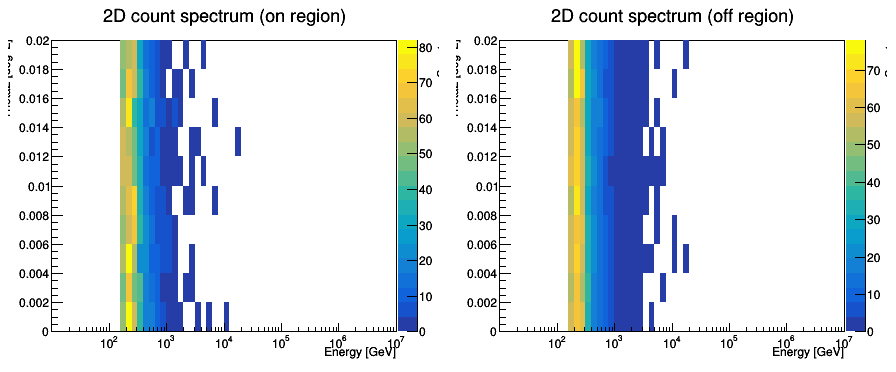

In [3]:
plotRoot(hOn, hOff, logx=True, logx2=True)

### Raw Data (Null model)

In [4]:
checkError(hOff, signal)

[Error] p_off is 0, (E, theta) = (10.1 TeV, 0.001 deg).
[Error] p_off is 0, (E, theta) = (19.7 TeV, 0.013 deg).
[Error] The number of events with p_off of 0 is 2 events.


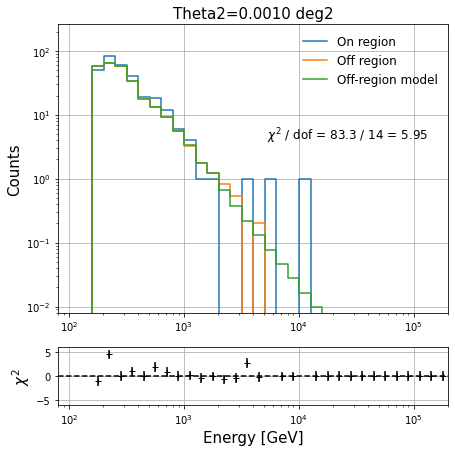

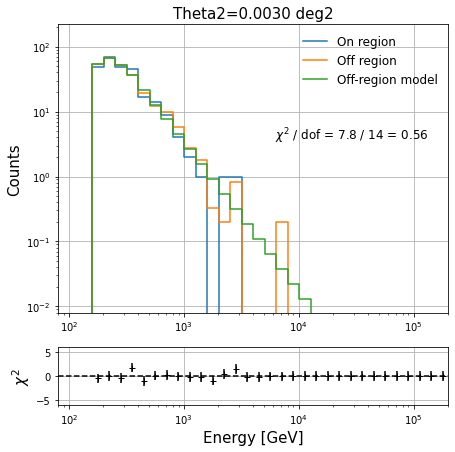

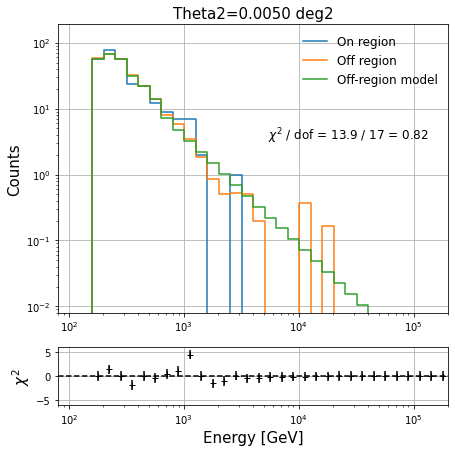

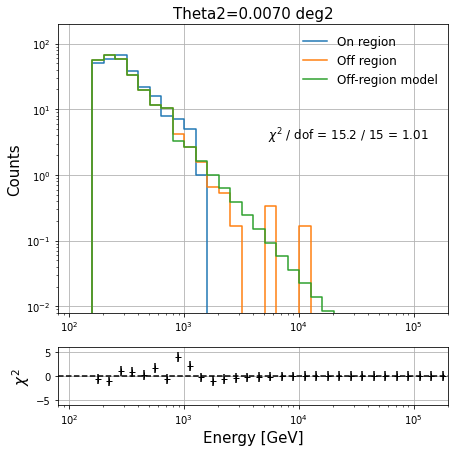

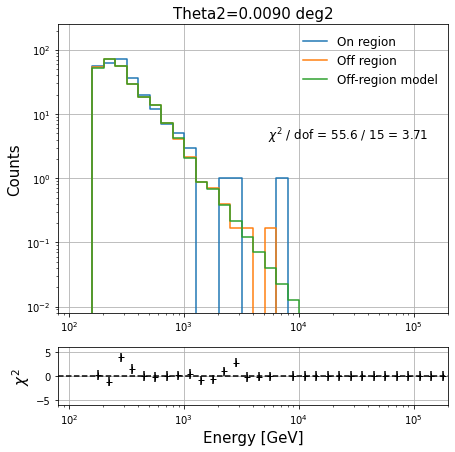

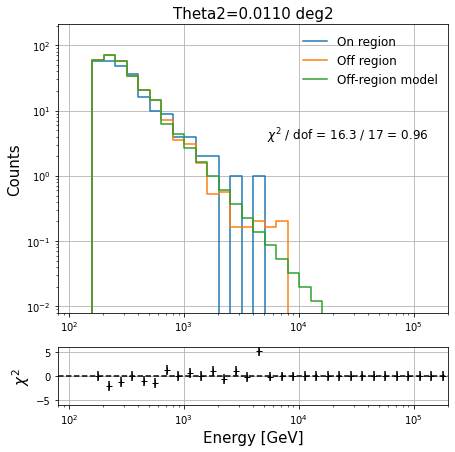

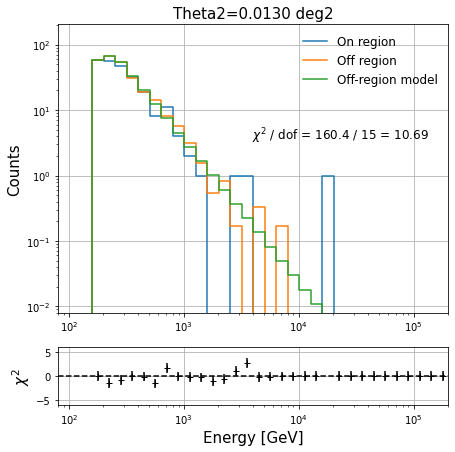

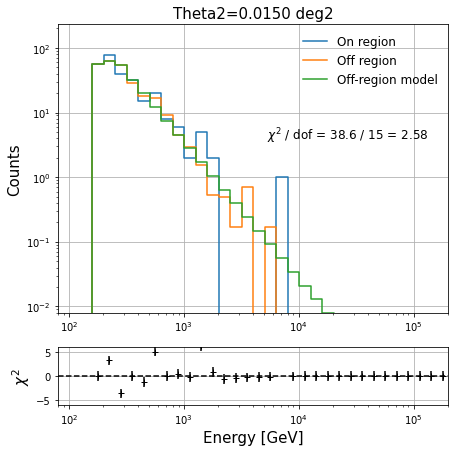

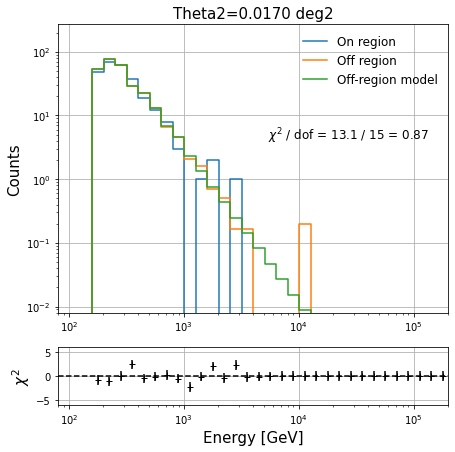

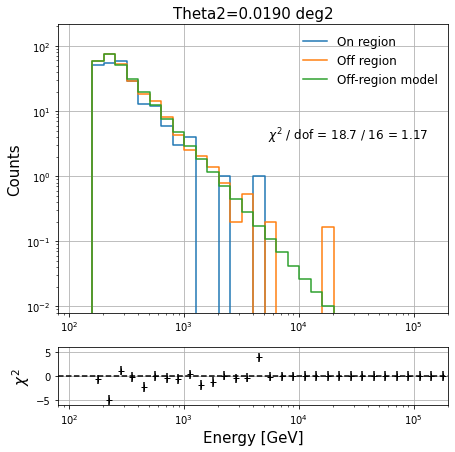

In [5]:
Likelihood.eventdisplay.plotTwoHist_2D(hOn, hOff, hOff_m, save=True)

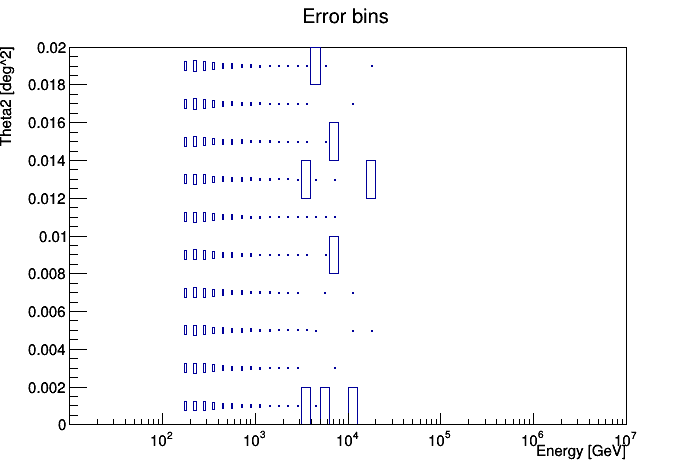

In [6]:
c = TCanvas()
hErr.DrawClone("box")
hOff.DrawClone("same box")
c.SetLogx()
c.Draw()

### Extrapolation method

In [13]:
cnts_off = Likelihood.eventdisplay.bkg_ex_2D(events, const.energyEdges, thetaEdges(0.02))

In [14]:
hOff_ex = hOff.Clone()
hOff_ex.Reset()
for i in range(1, hOff_ex.GetNbinsX()+1):
    for j in range(1, hOff_ex.GetNbinsY()+1):
        hOff_ex.SetBinContent(i, j, cnts_off[i-1][j-1])

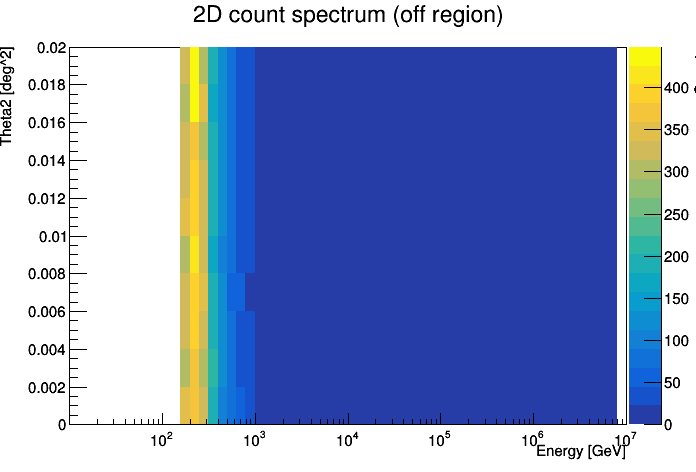

In [15]:
c = TCanvas()
hOff_ex.Draw("colz")
c.SetLogx()
c.Draw()

### Likelihood analysis and upper limits

In [16]:
hBkg = convertToPDF(hOff, norm=True)
hBkg_ex = convertToPDF(hOff_ex, norm=True)

[Log] Package      : EventDisplay
[Log] Dwarf        : segue_1
[Log] Channel      : tt
[Log] Dataset      : Extended
[Log] Dimention    : 1
[Log] Background   : None
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 100 GeV
[Log] Maximum mass : 32 TeV


  0%|          | 0/20 [00:00<?, ?it/s]

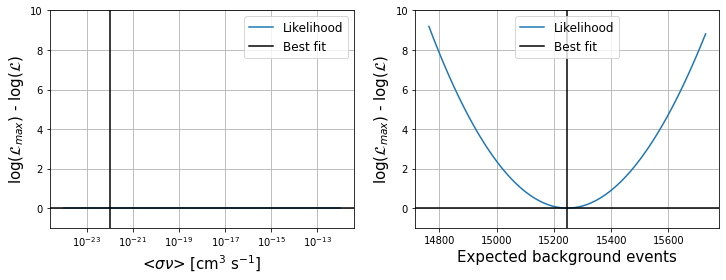

[Log, Error] The upper limit is not estimated (M=0.100 TeV).
[Log] Upper limits are saved in '/Users/dtak/Research/DarkMatter/Output/EventDisplay_segue_1_tt_1D_null.npy'
[Log] Package      : EventDisplay
[Log] Dwarf        : segue_1
[Log] Channel      : tt
[Log] Dataset      : Extended
[Log] Dimention    : 1
[Log] Background   : Extrapolation (ex)
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 100 GeV
[Log] Maximum mass : 32 TeV


  0%|          | 0/20 [00:00<?, ?it/s]

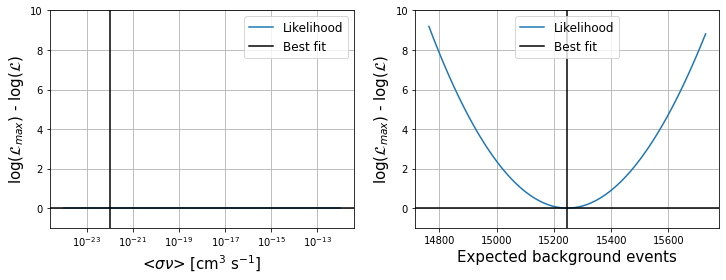

[Log, Error] The upper limit is not estimated (M=0.100 TeV).
[Log] Upper limits are saved in '/Users/dtak/Research/DarkMatter/Output/EventDisplay_segue_1_tt_1D_ex.npy'
[Log] Package      : EventDisplay
[Log] Dwarf        : segue_1
[Log] Channel      : tt
[Log] Dataset      : Extended
[Log] Dimention    : 2
[Log] Background   : None
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 100 GeV
[Log] Maximum mass : 32 TeV


  0%|          | 0/20 [00:00<?, ?it/s]

[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.


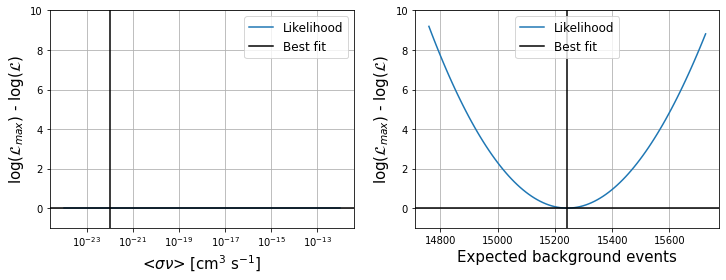

[Log, Error] The upper limit is not estimated (M=0.100 TeV).
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 4 events have p_bkg of 0. They are ignored when calculating the likel

  0%|          | 0/20 [00:00<?, ?it/s]

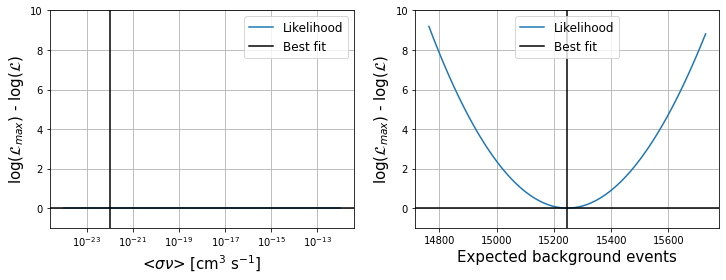

[Log, Error] The upper limit is not estimated (M=0.100 TeV).
[Log] Upper limits are saved in '/Users/dtak/Research/DarkMatter/Output/EventDisplay_segue_1_tt_2D_ex.npy'
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 ******************************************************************

Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory

In [5]:
dwarf = "segue_1"
decay = "tt"
package="EventDisplay"
mass = np.logspace(2, 4.5, 20)
jSeed = defaultNum[dwarf]


Likelihood.calcUpperLimits(dwarf, decay, package=package, averagedIRF=True, ext=True, jSeed=jSeed,                        
                           mass=mass, method=2, addTheta=False, bkgModel=None)

Likelihood.calcUpperLimits(dwarf, decay, package=package, averagedIRF=True, ext=True, jSeed=jSeed,   
                           mass=mass, method=2, addTheta=False, bkgModel="ex")

Likelihood.calcUpperLimits(dwarf, decay, package=package, averagedIRF=True, ext=True, jSeed=jSeed,   
                           mass=mass, method=2, addTheta=True, bkgModel=None)

Likelihood.calcUpperLimits(dwarf, decay, package=package, averagedIRF=True, ext=True, jSeed=jSeed,   
                           mass=mass, method=2, addTheta=True, bkgModel="ex")


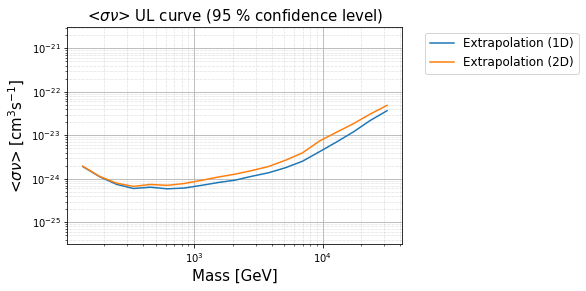

In [6]:
#Likelihood.plotULcurve("EventDisplay_segue_1_tt_1D_null", label="Null (1D)")
Likelihood.plotULcurve("EventDisplay_segue_1_tt_1D_ex", label="Extrapolation (1D)")
#Likelihood.plotULcurve("EventDisplay_segue_1_tt_2D_null", label="Null (2D)")
Likelihood.plotULcurve("EventDisplay_segue_1_tt_2D_ex", label="Extrapolation (2D)")